## Convolutional Neural Network - Sign Language

In [12]:
%pylab inline
import pandas as pd
from pylab import *
import numpy as np
from tqdm import trange

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/kenyi/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'power', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [13]:
df_train = pd.read_csv('training_sets/sign_mnist_train.csv')
df_test  = pd.read_csv('test_sets/sign_mnist_test.csv')

In [14]:
#print(df_train.head())
# 1st column is label
# rest of them are pixels 1-784 = 28*28
Y_train = df_train.iloc[:,0].to_numpy()
X_train = df_train.iloc[:,1:].to_numpy().reshape((-1,28,28))
Y_test  = df_test.iloc[:,0].to_numpy()
X_test  = df_test.iloc[:,1:].to_numpy().reshape((-1,28,28))

X_train = X_train.reshape((-1, 1, 28, 28))  # Shape [batch_size, channels, height, width]
X_test = X_test.reshape((-1, 1, 28, 28))

print(X_train.shape)
print(Y_train.shape)

(27455, 1, 28, 28)
(27455,)


In [15]:
# amount of classes 
print('unique number of labels')
num_classes = np.unique(Y_train) 
print(num_classes)


unique number of labels
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


## ConvNet
Images of size 28x28, single channel

this block x3
- convnet -> relu
- convnet -> relu -> pool
 
at the end a fully connected layer


In [16]:
import torch 
import torch.nn as nn
from tqdm import trange, tqdm
import time

class TinyModel(nn.Module):
    def __init__(self, num_classes=25):
        super(TinyModel, self).__init__()
        # block 1
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=8 , kernel_size=3)
        self.act1 = nn.ReLU()
        self.cnn2 = nn.Conv2d(in_channels=8 ,out_channels=16, kernel_size=3)
        self.act2 = nn.ReLU()
        self.pool1= nn.MaxPool2d(kernel_size=2, stride=2)
        # block 2
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.act3 = nn.ReLU()
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.act4 = nn.ReLU()
        self.pool2= nn.MaxPool2d(kernel_size=2, stride=2)
        # fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # adjust 5x5 based on input size
        self.fc2 = nn.Linear(128, num_classes)  # 24 classes
    def forward(self, x):
        # Block 1
        x = self.cnn1(x)
        x = self.act1(x)
        x = self.cnn2(x)
        x = self.act2(x)
        x = self.pool1(x)  # After pooling, size is reduced

        # Block 2
        x = self.cnn3(x)
        x = self.act3(x)
        x = self.cnn4(x)
        x = self.act4(x)
        x = self.pool2(x)  # After pooling, size is reduced further

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*4*4)

        # Fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)

        return x

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.01, accuracy: 1.00: 100%|██████████| 1000/1000 [00:22<00:00, 43.89it/s]


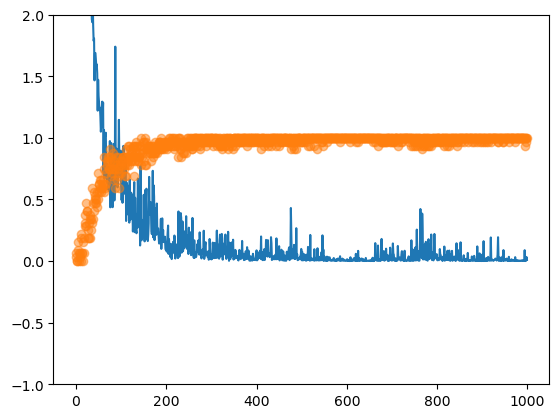

In [18]:
import matplotlib.pyplot as plt

# Training

model = TinyModel()

# set loss function
loss_function = nn.CrossEntropyLoss()

# set optimizer
optim = torch.optim.Adam(model.parameters())

losses, accuracies = [], []
BS = 32

# training loop
loop_tam = 1000
for i in (t := trange(loop_tam)):
    # select a batch of size BS
    samp = np.random.randint(0,X_train.shape[0], size = (BS))
    X = torch.tensor(X_train[samp]).float()  # No need to reshape to 28*28, keep it as 28x28 with channel
    Y = torch.tensor(Y_train[samp]).long()
    # set all gradient contribution to zero
    optim.zero_grad()

    # perform forward pass
    out = model(X)

    # we want to the see the accuracy of the model as we progress with the iterations
    cat = torch.argmax(out,dim=1)
    accuracy = (cat == Y).float().mean()

    loss = loss_function(out, Y)

    # performa backward pass
    loss.backward()
    optim.step()

    # output some info
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description(f"Loss: {loss:.2f}, accuracy: {accuracy:.2f}")

plt.ylim(-1,2)
plot(losses)
plot(accuracies, 'o', alpha = 0.5)


In [20]:
# Evaluation
Y_test_pred = torch.argmax(model(torch.tensor(X_test).float()), dim=1).numpy()
(Y_test == Y_test_pred).mean()

0.8911042944785276